In [2]:
# Run shell command:
#   $ /Applications/Microsoft\ Edge.app/Contents/MacOS/Microsoft\ Edge --remote-debugging-port=9222

In [7]:
import json
import os
import operator
from dotenv import load_dotenv, find_dotenv
from typing_extensions import TypedDict
from typing import Annotated
from IPython.display import Image, display

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_mcp_adapters.client import MultiServerMCPClient

load_dotenv(find_dotenv())
google_api_key = os.getenv("GOOGLE_API_KEY")

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

def create_graph(state: GraphState, tools, model_chain):
    def should_continue(state: state):
        messages = state["messages"]
        last_message = messages[-1]
        if last_message.tool_calls:
            return "tools"
        return END

    def call_model(state: state):
        messages = state["messages"]
        response = model_chain.invoke(messages)
        return {"messages": [response]}

    tool_node = ToolNode(tools)
    workflow = StateGraph(state)
    workflow.add_node("agent", call_model)
    workflow.add_node("tools", tool_node)
    workflow.add_edge(START, "agent")
    workflow.add_conditional_edges("agent", should_continue, ["tools", END])
    workflow.add_edge("tools", "agent")
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app


In [8]:
async def run_query(query, graph):
    input_query = [
        HumanMessage([
            {
                "type": "text",
                "text": f"{query}"
            }
        ])
    ]

    config = {
        "configurable": {
            "thread_id": "12345"
        },
         "recursion_limit": 50
    }

    response = await graph.ainvoke({"messages": input_query}, config=config)
    print("response: ", response)
    print("=================================")
    print(response["messages"][-1].content)


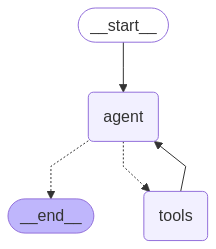

Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is not supported in schema, ignoring
Key 'additionalProperties' is not supported in schema, ignoring
Key '$schema' is

response:  {'messages': [HumanMessage(content=[{'type': 'text', 'text': '\nあなたはウェブフォームの自動入力に特化したAIエージェントです。  \nPlayWrite を使用して、現在表示されている申請フォームのページを実際に操作し、自動で入力を完了させてください。  \nこのタスクはテストコードの生成ではなく、「実際のブラウザ操作による入力と送信」を目的としています。\n\n以下の厳密な手順に従ってタスクを実行してください。\n\n---\n\n【ステップ1：ページ情報の取得】\n- 現在のページのHTMLソースを取得してください。\n- 入力フィールド、チェックボックス、ラジオボタン、ドロップダウン、ボタンなどの**インタラクティブ要素をすべて特定**してください。\n\n【ステップ2：フィールドへの入力】\n各フィールドに以下のダミーデータを一つずつ順番に入力してください：\n- テキストフィールド: `"テストデータ"`\n- メールアドレス: `"test@example.com"`\n- 電話番号: `"09012345678"`\n- 郵便番号: `"1234567"`（※ハイフンなし）\n- 住所: `"東京都新宿区1-2-3"`\n\n加えて以下の処理も行ってください：\n- チェックボックスやラジオボタン：**1つ以上選択**\n- ドロップダウン：**最初の選択肢を選択**\n\n⚠️ 入力は安定性を優先し、**1つずつ順番に実行**してください（複数入力の同時処理は避ける）。\n\n【ステップ3：次ページへの遷移】\n- 入力完了後、「次へ」「進む」などのボタンをクリックして次のページに進んでください。\n\n【ステップ4：エラーハンドリング】\n- 入力・クリックでエラーが発生した場合：\n   1. エラーの詳細を取得\n   2. 1回再試行\n   3. それでも失敗する場合は、エラー内容を記録して報告\n\n【ステップ5：繰り返し処理】\n- 次のページでも **ステップ1〜4を繰り返し実行**してください。\n- 最後のページに到達したら、**送信ボタンをクリック**してください。\n\n【ステップ6：最終確認】\n- フォーム送信後に成功メッセージまたはリ

In [ ]:
async def main():
   model = ChatGoogleGenerativeAI(
      model="gemini-2.0-flash",
      google_api_key=google_api_key,
      temperature=1.0,
   )
   with open("../mcp_config.json", "r") as f:
      mcp_config = json.load(f)
   message = [
       SystemMessage(content="""
あなたは高精度なAIエージェントです。ユーザーの質問に日本語で回答し、**必ず結論より前に思考・推論の過程を出力してください**。

あなたは「PlayWrite」というブラウザ自動操作ツールを使用して、Webサイトから必要な情報を取得できます。  
このツールを利用することでのみ外部情報を取得できます。**ツールから得られた情報以外（事前知識や推測）を使って回答してはいけません。**

---

【タスクの進め方（厳守）】

1. **質問を受け取ったら最初に次を明確に判断すること**：
   - 回答にツールの使用が必要かどうか
   - 取得すべき具体的な情報項目は何か
   - ツールの使用回数と順序（段階的に必要な情報を得る）

2. **情報取得が必要な場合は、ツールを使って適切にWebサイトへアクセスし、必要な情報をすべて取得してください。**

3. **すべての必要情報が揃ったあとにのみ、回答を作成してください。**

4. **思考過程 → 情報の要約 → 回答の結論** の順で出力してください。

---

【補足】

- サイトへのアクセスでエラーが発生した場合は、**必ず再試行してください**（一時的なネットワーク障害の可能性があります）。
- 情報が取得できなかった場合は、その理由と対処方法を明示してください。
- 回答に不要な推測を加えないでください。

---

あなたの目的は、「正確かつ信頼できる情報」をツール経由で取得し、その情報にもとづいて**透明性のある論理的なプロセスで回答を導くこと**です。
      """),
      MessagesPlaceholder("messages"),
   ]

   prompt = ChatPromptTemplate.from_messages(message)
   async with MultiServerMCPClient(mcp_config["mcpServers"]) as mcp_client:
      tools = mcp_client.get_tools()
      model_with_tools = prompt | model.bind_tools(tools)
      graph = create_graph(GraphState, tools, model_with_tools)
         
      # グラフをMermaid形式で描画して表示
      graph_image = graph.get_graph().draw_mermaid_png()
      display(Image(graph_image))

      query = """
あなたはウェブフォームの自動入力に特化したAIエージェントです。  
PlayWrite を使用して、現在表示されている申請フォームのページを実際に操作し、自動で入力を完了させてください。  
このタスクはテストコードの生成ではなく、「実際のブラウザ操作による入力と送信」を目的としています。

以下の厳密な手順に従ってタスクを実行してください。

---

【ステップ1：ページ情報の取得】
- 現在のページのHTMLソースを取得してください。
- 入力フィールド、チェックボックス、ラジオボタン、ドロップダウン、ボタンなどの**インタラクティブ要素をすべて特定**してください。

【ステップ2：フィールドへの入力】
各フィールドに以下のダミーデータを一つずつ順番に入力してください：
- テキストフィールド: `"テストデータ"`
- メールアドレス: `"test@example.com"`
- 電話番号: `"09012345678"`
- 郵便番号: `"1234567"`（※ハイフンなし）
- 住所: `"東京都新宿区1-2-3"`

加えて以下の処理も行ってください：
- チェックボックスやラジオボタン：**1つ以上選択**
- ドロップダウン：**最初の選択肢を選択**

⚠️ 入力は安定性を優先し、**1つずつ順番に実行**してください（複数入力の同時処理は避ける）。

【ステップ3：次ページへの遷移】
- 入力完了後、「次へ」「進む」などのボタンをクリックして次のページに進んでください。

【ステップ4：エラーハンドリング】
- 入力・クリックでエラーが発生した場合：
   1. エラーの詳細を取得
   2. 1回再試行
   3. それでも失敗する場合は、エラー内容を記録して報告

【ステップ5：繰り返し処理】
- 次のページでも **ステップ1〜4を繰り返し実行**してください。
- 最後のページに到達したら、**送信ボタンをクリック**してください。

【ステップ6：最終確認】
- フォーム送信後に成功メッセージまたはリダイレクト先URLを確認し、送信成功を検証してください。

【ステップ7：実行ログの記録】
- すべてのステップと入力操作をJSON形式で記録し、最終的な結果とともに出力してください。

---

【補足TIPS】
- XPathを使う場合は、柔軟なセレクタ（例：`contains(normalize-space(.), '次へ')`）を使用し、クラス名や完全一致テキストは避けてください。
- 画面遷移時のローディングや遅延に注意し、必要に応じて適切な待機を挟んでください。

---

この指示に従い、PlayWrite を用いた**段階的かつ確実なフォーム自動入力**を実行してください。
"""
      await run_query(query, graph)

await main()